In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import string

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
news_data = pd.read_csv('fake_or_real_news.csv')
news_data

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [5]:
# Basic info
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [6]:
# Check for null values
news_data.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [7]:
# Check for duplicates
news_data.duplicated().sum()

0

In [8]:
news_data.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

In [9]:
# Drop irrelevant columns
news_data = news_data[['text', 'label']]
news_data

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL
...,...,...
6330,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL


### Exploratory Data Analaysis (EDA)

In [10]:
news_data['label'].value_counts()/len(news_data)*100

label
REAL    50.055249
FAKE    49.944751
Name: count, dtype: float64

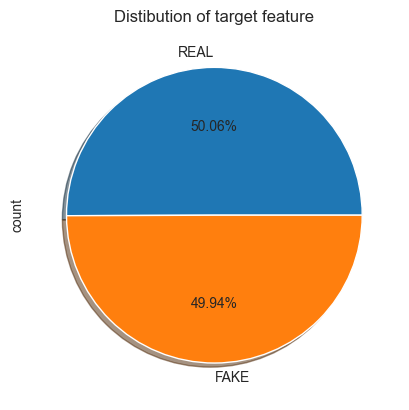

In [11]:
news_data['label'].value_counts().plot(kind='pie', autopct='%.2f%%', shadow=True)
plt.title("Distibution of target feature")
plt.show()

In [12]:
# Character count
news_data['num_characters'] = news_data['text'].apply(len)
# Word count
news_data['num_words'] = news_data['text'].apply(lambda x: len(nltk.word_tokenize(x)))
# Sentences count
news_data['num_sentences'] = news_data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [13]:
news_data.head()

,text,label,num_characters,num_words,num_sentences
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518,1473,87
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646,517,26
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543,484,16
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660,498,17
4,It's primary day in New York and front-runners...,REAL,1840,376,21


In [14]:
news_data[news_data['label']=='REAL'].describe()

,num_characters,num_words,num_sentences
count,3171.000000,3171.000000,3171.000000
mean,5292.160202,1017.897824,39.256071
std,4348.288284,849.433647,34.176634
min,43.000000,8.000000,1.000000
25%,2729.500000,521.000000,20.000000
50%,4683.000000,896.000000,34.000000
75%,6829.500000,1310.000000,50.000000
max,44039.000000,9003.000000,406.000000


In [15]:
news_data[news_data['label']=='FAKE'].describe()

,num_characters,num_words,num_sentences
count,3164.000000,3164.000000,3164.000000
mean,4121.046460,784.309418,29.305310
std,5680.232733,1103.474726,48.125432
min,1.000000,0.000000,0.000000
25%,1283.500000,244.000000,9.000000
50%,2558.000000,490.000000,18.000000
75%,5027.000000,950.000000,35.000000
max,115372.000000,23966.000000,1344.000000


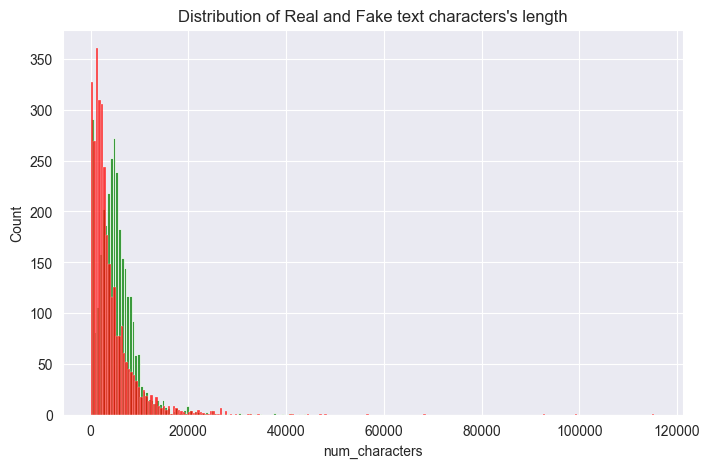

In [16]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(8,5))
sns.histplot(news_data[news_data['label']=='REAL']['num_characters'], color='green')
sns.histplot(news_data[news_data['label']=='FAKE']['num_characters'], color='red')
plt.title("Distribution of Real and Fake text characters's length")
plt.show()

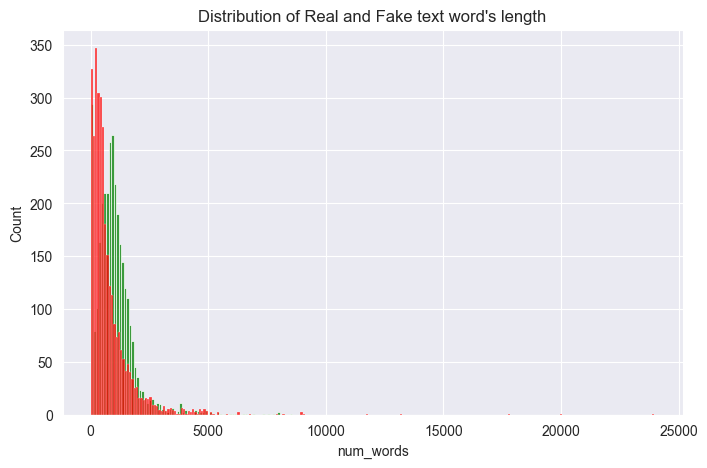

In [17]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(8,5))
sns.histplot(news_data[news_data['label']=='REAL']['num_words'], color='green')
sns.histplot(news_data[news_data['label']=='FAKE']['num_words'], color='red')
plt.title("Distribution of Real and Fake text word's length")
plt.show()

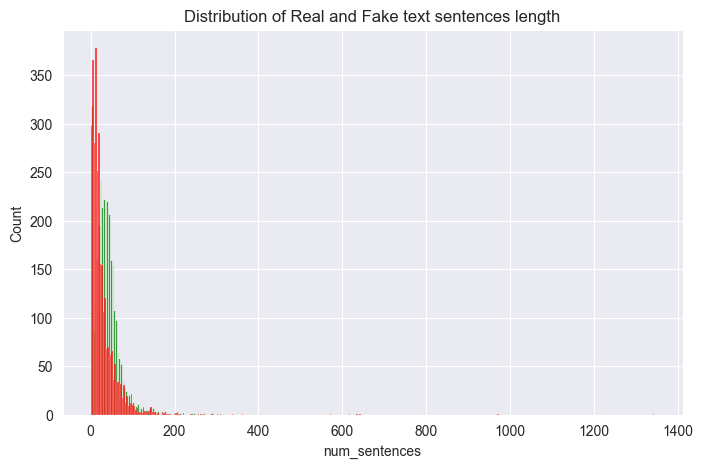

In [18]:
# Histogram for 'ham' and 'spam' text
plt.figure(figsize=(8,5))
sns.histplot(news_data[news_data['label']=='REAL']['num_sentences'], color='green')
sns.histplot(news_data[news_data['label']=='FAKE']['num_sentences'], color='red')
plt.title("Distribution of Real and Fake text sentences length")
plt.show()

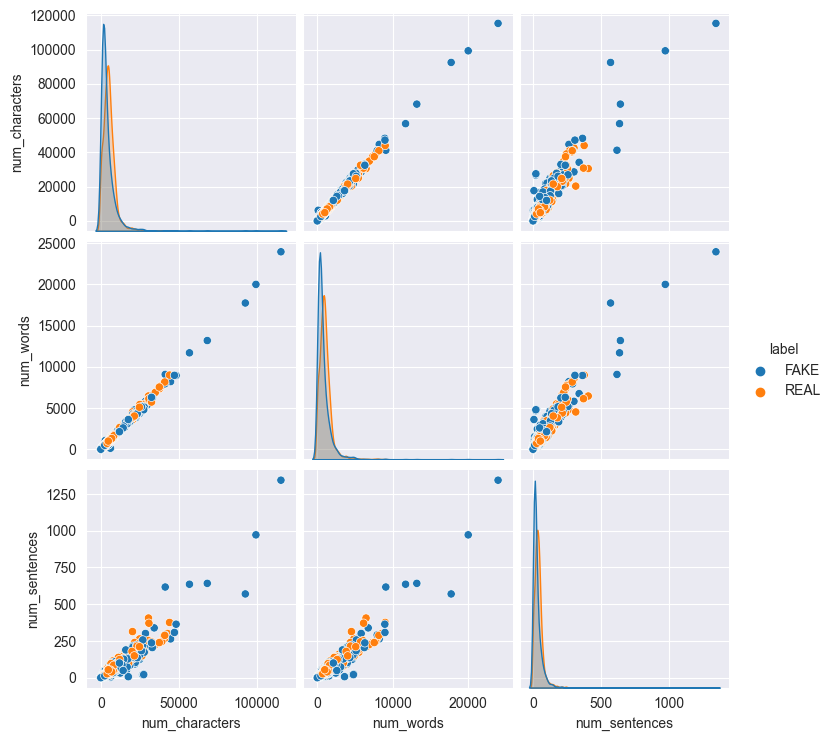

In [19]:
sns.pairplot(news_data, hue='label')
plt.show()

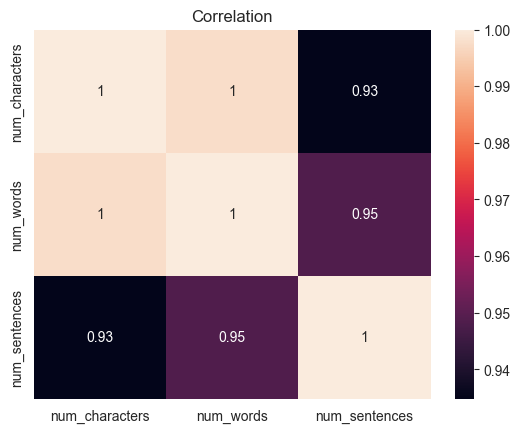

In [20]:
# Correlation
corr = news_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.title("Correlation")
plt.show()

### Data Preprocessing

In [21]:
nltk.download('stopwords')
string.punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
ps = PorterStemmer()

In [23]:
# Function for text preprocessing
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for j in text:
        if j not in stopwords.words('english') and j not in string.punctuation:
            y.append(j)
            
    text = y[:]
    y.clear()
    
    for k in text:
        y.append(ps.stem(k))
        
    return " ".join(y)

In [24]:
news_data

,text,label,num_characters,num_words,num_sentences
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,7518,1473,87
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,2646,517,26
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,2543,484,16
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,2660,498,17
4,It's primary day in New York and front-runners...,REAL,1840,376,21
...,...,...,...,...,...
6330,The State Department told the Republican Natio...,REAL,4076,726,27
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE,14323,2594,49
6332,Anti-Trump Protesters Are Tools of the Oligar...,FAKE,11974,2137,100
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",REAL,6991,1313,40
